## 1D Advection PDE:

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1], \quad t > 0 $
## Initial Condition:
$ u(x, 0) = u_0(x) = 2\pi x \quad \text{for} \quad x \in [0, 1]$

In [ ]:
dt/1 = dx/1 = du/0  , u=c; x-t=c1

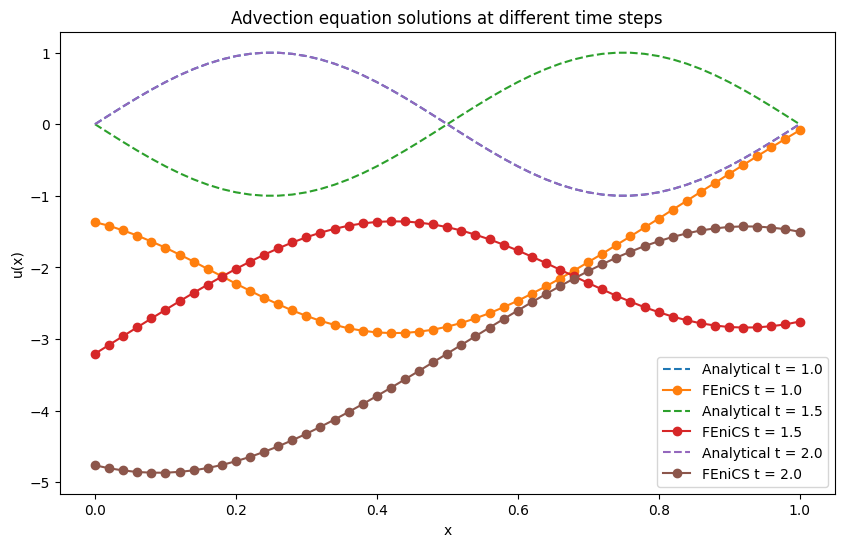

In [1]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # Total time
dt = 0.01  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed (here 1)

# Step 1: Create a 1D mesh on the interval [0, 1] with 50 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 50, [0, 1])

# Step 2: Define function space (Lagrange elements of degree 1 for linear basis functions)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition: u(x, 0) = (2*pi*x)
u_n = fem.Function(V)
u_n.interpolate(lambda x: np.sin(2 * np.pi * x[0]))

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using a backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# Step 6: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L)

# Store solutions for desired time steps
times_to_store = [1.0, 1.5, 2.0]
stored_solutions = {}

for n in range(num_steps+1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store the solution at specific time steps
    current_time = (n + 0) * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0) \
            or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 7: Compare FEniCS solutions with analytical solutions at different time steps
# Get the coordinates of the mesh points (for FEniCS solution)
mesh_points = V.tabulate_dof_coordinates()[:, 0]

# Plot numerical and analytical solutions at different time steps
plt.figure(figsize=(10, 6))

for time in times_to_store:
    # Analytical solution at this time step
    u_analytical = np.sin(2 * np.pi * (mesh_points - c * time))

    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]

    # Plotting the solutions
    plt.plot(mesh_points, u_analytical, linestyle="dashed", label=f"Analytical t = {time}")
    plt.plot(mesh_points, u_fenics, marker='o', linestyle="solid", label=f"FEniCS t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()


Error and convergence computation

In [2]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt


# function to solve the advection pde
def solve_advection(N=50, degree=1, dt=0.01, T=2.0, c=1.0):
    # Create a 1D mesh on the interval [0, 1] with N elements
    domain = mesh.create_interval(MPI.COMM_WORLD, N, [0, 1])

    # Define the function space
    V = fem.functionspace(domain, ("Lagrange", degree))

    # Initial condition: u(x, 0) = 2*pi*x
    u_n = fem.Function(V)
    u_n.interpolate(lambda x: np.exp(2 * np.pi * x[0]))

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Weak form for the advection equation using a backward Euler method
    a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
    L = inner(u_n, v) * dx

    # Time-stepping loop
    u_new = fem.Function(V)  # Solution at the new time step
    problem = LinearProblem(a, L)

    # Store solutions at specific time steps (for comparison with exact solution)
    times_to_store = [1.0, 1.5, 2.0]
    stored_solutions = {}

    num_steps = int(T / dt)
    for n in range(num_steps + 1):
        # Solve the linear system for u at the new time step
        u_new = problem.solve()

        # Update the solution for the next time step
        u_n.x.array[:] = u_new.x.array[:]

        # Store the solution at specific time steps
        current_time = n * dt
        if np.isclose(current_time, 1.0) or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
            stored_solutions[current_time] = u_n.x.array.copy()

    return stored_solutions, V

In [6]:
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

# Mesh resolutions to test
Ns = [10, 20, 40, 80, 160, 200]
Es = np.zeros(len(Ns), dtype=np.float64)  # L2 errors
hs = np.zeros(len(Ns), dtype=np.float64)  # Mesh sizes

# Function to compute L2 error for each N
def compute_L2_error(V, u_fenics, time, c=1.0):
    mesh_points = V.tabulate_dof_coordinates()[:, 0]

    # Analytical solution at this time step
    u_analytical = np.exp(2 * np.pi * (mesh_points - c * time))
    
    # Compute the L2 error between the numerical and analytical solutions
    error = np.sqrt(np.sum((u_fenics - u_analytical) ** 2) * (1 / len(mesh_points)))
    return error

# Loop over mesh resolutions
for i, N in enumerate(Ns):
    # Solve the advection equation for each N
    stored_solutions, V = solve_advection(N=N, degree=1, dt=1/500, T=2.0, c=1.0)
    
    # Get the last solution (at t = 2.0) for error calculation
    u_fenics = stored_solutions[2.0]

    # Compute L2 error at final time t = 2.0
    Es[i] = compute_L2_error(V, u_fenics, time=2.0, c=1.0)

    # Mesh size h
    hs[i] = 1.0 / N
    
    # Print the error for each mesh resolution
    comm = V.mesh.comm
    if comm.rank == 0:
        print(f"h: {hs[i]:.2e}, L2 Error: {Es[i]:.2e}")

# Compute the convergence rates
rates = np.log(Es[1:] / Es[:-1]) / np.log(hs[1:] / hs[:-1])

# Print the convergence rates
if comm.rank == 0:
    print(f"Convergence rates: {rates}")

h: 1.00e-01, L2 Error: 3.59e+03
h: 5.00e-02, L2 Error: 3.65e+03
h: 2.50e-02, L2 Error: 3.66e+03
h: 1.25e-02, L2 Error: 3.65e+03
h: 6.25e-03, L2 Error: 3.65e+03
h: 5.00e-03, L2 Error: 3.65e+03
Convergence rates: [-0.02213713 -0.00249947  0.00091968  0.0010035   0.00075856]
